# Final Model

Here we will review our final model and it's performance on the train and test data sets.

The final model is a **Logistic Regression** with learning rate of **0.001**.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Import Scipy Models
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Train/Test Split

First we will define our features that we chose based on findings in the exploratory analysis.
The features we will use are:
- Age
- Booking Window Days
- Hipertension
- Scholarship
- Diabetes
- Handcap
- SMS Received
- Scheduled House
- Appointment Day of Week
- Percentage of previous no-shows for the patient ("No-show_user_mean")
- Percentage of previous no-shows for the patients neighbourhood ("No-show_neighbourhood_mean")

In [2]:
data = pd.read_csv('../data/clean_data.csv')

_FEATURES = ['Age', 'booking_window_days', 'Hipertension', 'Scholarship', 
             'Diabetes', 'Handcap', 'SMS_received', 'ScheduledHour', 
             'AppointmentDayOfWeek']
_TARGET = 'No-show'

In [3]:
def train_test_add_features(data):
    skf = StratifiedKFold(n_splits=2)

    X = data[_FEATURES].values 
    y = data[_TARGET].values 

    for train_index, test_index in skf.split(X, y):
        # Calculate the user history
        train = data.iloc[train_index]
        train = train.join(train.groupby('PatientId')['No-show'].agg(np.mean), on='PatientId', rsuffix='_user_mean')
        train = train.join(train.groupby('Neighbourhood')['No-show'].agg(np.mean), on='Neighbourhood', rsuffix='_neighbourhood_mean')
        train = train.join(train.groupby('PatientId')['No-show'].agg('sum'), on='PatientId', rsuffix='_sum')
        #train = train.join(train.groupby('PatientId')['Age'].count(), on='PatientId', rsuffix='_count')
        
        test = data.iloc[test_index]
        
        test = pd.merge(test, train[['PatientId', 'No-show_user_mean']], on='PatientId', how='left') 
        test.at[test['No-show_user_mean'].isna(), 'No-show_user_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_neighbourhood_mean']], on='PatientId', how='left') 
        test.at[test['No-show_neighbourhood_mean'].isna(), 'No-show_neighbourhood_mean'] = 1
        
        test = pd.merge(test, train[['PatientId', 'No-show_sum']], on='PatientId', how='left')
        test.at[test['No-show_sum'].isna(), 'No-show_sum'] = 0
        
        #test = pd.merge(test, train[['PatientId', 'Age_count']], on='PatientId', how='left')
        #test.at[test['Age_count'].isna(), 'Age_count'] = 0
        
        X_train = train[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_train = train[_TARGET].values
        
        X_test = test[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
        y_test = test[_TARGET].values
        
        break

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_add_features(data)


### Model

We will now train our model using the hyperparemters found to perform best on this dataset. We will then predict the patients appointment attendance.

In [7]:
model = LogisticRegression(random_state=0, class_weight='balanced', C=0.001)
model.fit(X_train, y_train)
print('Score: %f' % (model.score(X_test, y_test)))

y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Precision: %f' % (precision))
print('Recall: %f' % (recall))


/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score: 0.926952
Precision: 0.931139
Recall: 0.926952


### Evaluation

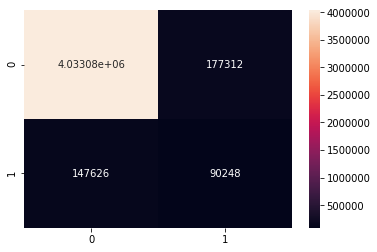

In [8]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

# Final Result

And so our final model acheived the following results.
- Precision: **0.93**
- Recall: **0.93**